# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import dataframe_image as dfi
import matplotlib.ticker
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
current_working_directory = os.environ.get("PWD")
if current_working_directory:
    os.chdir(current_working_directory)

sns.set()
matplotlib.rcParams['figure.figsize'] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")

### COVID-19 Cases

In [3]:
spain_region_country_name = "Spain"
spain_region_country_code = "ES"

confirmed_df = pd.read_csv("https://covid19tracking.narrativa.com/csv/confirmed.csv")

radar_covid_countries = {spain_region_country_name}
# radar_covid_regions = { ... }

confirmed_df = confirmed_df[confirmed_df["Country_EN"].isin(radar_covid_countries)]
# confirmed_df = confirmed_df[confirmed_df["Region"].isin(radar_covid_regions)]
# set(confirmed_df.Region.tolist()) == radar_covid_regions

In [4]:
confirmed_country_columns = list(filter(lambda x: x.startswith("Country_"), confirmed_df.columns))
confirmed_regional_columns = confirmed_country_columns + ["Region"]
confirmed_df.drop(columns=confirmed_regional_columns, inplace=True)
confirmed_df = confirmed_df.sum().to_frame()
confirmed_df.tail()

,0
2020-09-15,1206334.0
2020-09-16,1228720.0
2020-09-17,1251302.0
2020-09-18,1280080.0
2020-09-19,1280080.0


In [5]:
confirmed_df.reset_index(inplace=True)
confirmed_df.columns = ["sample_date_string", "cumulative_cases"]
confirmed_df.sort_values("sample_date_string", inplace=True)
confirmed_df["new_cases"] = confirmed_df.cumulative_cases.diff()
confirmed_df["rolling_mean_new_cases"] = confirmed_df.new_cases.rolling(7).mean().round()
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,rolling_mean_new_cases
236,2020-09-15,1206334.0,18874.0,19615.0
237,2020-09-16,1228720.0,22386.0,20280.0
238,2020-09-17,1251302.0,22582.0,20431.0
239,2020-09-18,1280080.0,28778.0,21061.0
240,2020-09-19,1280080.0,0.0,21061.0


In [6]:
extraction_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_date]
extraction_previous_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_previous_date].copy()

if extraction_date_confirmed_df.empty and \
    not extraction_previous_date_confirmed_df.empty:
        extraction_previous_date_confirmed_df["sample_date_string"] = extraction_date
        extraction_previous_date_confirmed_df["new_cases"] = \
            extraction_previous_date_confirmed_df.rolling_mean_new_cases
        extraction_previous_date_confirmed_df["cumulative_cases"] = \
            extraction_previous_date_confirmed_df.new_cases + \
            extraction_previous_date_confirmed_df.cumulative_cases
        confirmed_df = confirmed_df.append(extraction_previous_date_confirmed_df)
        
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,rolling_mean_new_cases
236,2020-09-15,1206334.0,18874.0,19615.0
237,2020-09-16,1228720.0,22386.0,20280.0
238,2020-09-17,1251302.0,22582.0,20431.0
239,2020-09-18,1280080.0,28778.0,21061.0
240,2020-09-19,1280080.0,0.0,21061.0


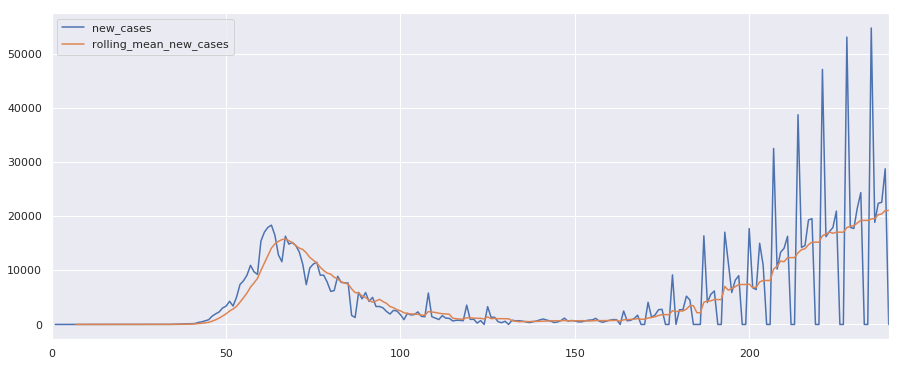

In [7]:
confirmed_df[["new_cases", "rolling_mean_new_cases"]].plot()

### Extract API TEKs

In [8]:
from Modules.RadarCOVID import radar_covid

exposure_keys_multi_region_df = \
    radar_covid.download_last_radar_covid_exposure_keys(days=14)
exposure_keys_multi_region_df = exposure_keys_multi_region_df[[
    "sample_date_string", "source_url", "region", "key_data"]]
active_regions = \
    exposure_keys_multi_region_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions

['ES']

In [9]:
multi_region_summary_df = exposure_keys_multi_region_df.groupby(
    ["sample_date_string", "region"]).key_data.nunique().reset_index() \
    .pivot(index="sample_date_string", columns="region") \
    .sort_index(ascending=False)
multi_region_summary_df.rename(columns={"key_data": "tek_count"}, inplace=True)
multi_region_summary_df.head()

,tek_count
region,ES
sample_date_string,
2020-09-19,2
2020-09-18,40
2020-09-17,64
2020-09-16,67
2020-09-15,67


In [10]:
exposure_keys_multi_region_excluding_spain_df = \
    exposure_keys_multi_region_df[exposure_keys_multi_region_df.region != spain_region_country_code]
active_regions_excluding_spain = \
    exposure_keys_multi_region_excluding_spain_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions_excluding_spain

[]

In [11]:
exposure_keys_df = exposure_keys_multi_region_df[
    exposure_keys_multi_region_df.region == spain_region_country_code]
exposure_keys_df.head()

,sample_date_string,source_url,region,key_data
0,2020-09-19,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,d4787a07-8b0b-58cc-b9e3-a94b0928d497
1,2020-09-19,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,fc2611d2-31a3-2f44-1685-eec67c53eadd
0,2020-09-18,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,929af33f-4c54-9b8a-cf3a-a6eafed8dd0e
1,2020-09-18,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,8c6b618f-134c-6652-f0e6-f2244fb4002c
2,2020-09-18,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,bdfba1d7-50f3-b91c-be93-395738b4993e


In [12]:
exposure_keys_summary_df = \
    exposure_keys_df.groupby(["sample_date_string", "region"]).key_data.nunique().to_frame()
exposure_keys_summary_df = \
    exposure_keys_summary_df.reset_index().set_index("sample_date_string")
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "tek_count"}, inplace=True)
exposure_keys_summary_df.head()

,region,tek_count
sample_date_string,,
2020-09-19,ES,2
2020-09-18,ES,40
2020-09-17,ES,64
2020-09-16,ES,67
2020-09-15,ES,67


### Dump API TEKs

In [13]:
tek_list_df = exposure_keys_df[["sample_date_string", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    "sample_date").tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour
tek_list_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    "Data/TEKs/Current/RadarCOVID-TEKs.json",
    lines=True, orient="records")
tek_list_df.drop(columns=["extraction_date_with_hour"]).to_json(
    "Data/TEKs/Daily/RadarCOVID-TEKs-" + extraction_date + ".json",
    lines=True, orient="records")
tek_list_df.to_json(
    "Data/TEKs/Hourly/RadarCOVID-TEKs-" + extraction_date_with_hour + ".json",
    lines=True, orient="records")
tek_list_df.head()

,sample_date,tek_list,extraction_date,extraction_date_with_hour
0,2020-09-06,"[385e7ed2-4285-fcfd-18e4-3197e44fc261, d484384...",2020-09-19,2020-09-19@23
1,2020-09-07,"[4f22f269-acd0-9cbd-5082-87826578c387, 402a892...",2020-09-19,2020-09-19@23
2,2020-09-08,"[64d2f594-3e1e-250e-b2e2-103c46f3a4a9, b8121a9...",2020-09-19,2020-09-19@23
3,2020-09-09,"[1f0a0575-26d0-44c1-7b58-0a0193ddfa44, 03a9a6b...",2020-09-19,2020-09-19@23
4,2020-09-10,"[6954f38b-22cd-d093-f288-7cdb50f2951d, 1a86957...",2020-09-19,2020-09-19@23


### Load TEK Dumps

In [14]:
import glob

def load_extracted_teks(mode, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame()
    paths = list(reversed(sorted(glob.glob(f"Data/TEKs/{mode}/RadarCOVID-TEKs-*.json"))))
    if limit:
        paths = paths[:limit]
    for path in paths:
        logging.info(f"Loading TEKs from '{path}'...")
        iteration_extracted_teks_df = pd.read_json(path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    return extracted_teks_df

### Daily New TEKs

In [15]:
daily_extracted_teks_df = load_extracted_teks(mode="Daily", limit=14)
daily_extracted_teks_df.head()

,sample_date,tek_list,extraction_date
0,2020-09-06,"[385e7ed2-4285-fcfd-18e4-3197e44fc261, d484384...",2020-09-19
1,2020-09-07,"[4f22f269-acd0-9cbd-5082-87826578c387, 402a892...",2020-09-19
2,2020-09-08,"[64d2f594-3e1e-250e-b2e2-103c46f3a4a9, b8121a9...",2020-09-19
3,2020-09-09,"[1f0a0575-26d0-44c1-7b58-0a0193ddfa44, 03a9a6b...",2020-09-19
4,2020-09-10,"[6954f38b-22cd-d093-f288-7cdb50f2951d, 1a86957...",2020-09-19


In [16]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-09-06,"{a9e87852-532a-6b1e-7662-170574c423da, 8f11603..."
2020-09-07,"{a9e87852-532a-6b1e-7662-170574c423da, 8f11603..."
2020-09-08,"{a9e87852-532a-6b1e-7662-170574c423da, 8f11603..."
2020-09-09,"{40d54a8d-dd4a-e611-1275-c28ef0ea300e, 8f11603..."
2020-09-10,"{40d54a8d-dd4a-e611-1275-c28ef0ea300e, 8f11603..."


In [17]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "new_tek_count",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.head()

,sample_date_string,new_tek_count
0,2020-09-06,NaN
1,2020-09-07,52.0
2,2020-09-08,44.0
3,2020-09-09,67.0
4,2020-09-10,45.0


In [18]:
new_tek_devices_df = daily_extracted_teks_df.copy()
new_tek_devices_df["new_sample_extraction_date"] = \
    pd.to_datetime(new_tek_devices_df.sample_date) + datetime.timedelta(1)
new_tek_devices_df["extraction_date"] = pd.to_datetime(new_tek_devices_df.extraction_date)

new_tek_devices_df = new_tek_devices_df[
    new_tek_devices_df.new_sample_extraction_date == new_tek_devices_df.extraction_date]
new_tek_devices_df.head()

,sample_date,tek_list,extraction_date,new_sample_extraction_date
12,2020-09-18,"[929af33f-4c54-9b8a-cf3a-a6eafed8dd0e, 8c6b618...",2020-09-19,2020-09-19
12,2020-09-17,"[7967f68b-ead3-bdb7-a7ae-bcb78220c852, fb2d0e2...",2020-09-18,2020-09-18
12,2020-09-16,"[713a8fac-9ef2-0c13-0162-7397da9e7778, ca13a5b...",2020-09-17,2020-09-17
12,2020-09-15,"[f6f1a72b-e029-5cc3-06ca-7817dc59b26e, 422efa3...",2020-09-16,2020-09-16
12,2020-09-14,"[d4bfbea7-3eaf-535f-3faa-aaedf929f579, ae4ae0c...",2020-09-15,2020-09-15


In [19]:
new_tek_devices_df.set_index("extraction_date", inplace=True)
new_tek_devices_df = new_tek_devices_df.tek_list.apply(lambda x: len(set(x))).to_frame()
new_tek_devices_df.reset_index(inplace=True)
new_tek_devices_df.rename(columns={
    "extraction_date": "sample_date_string",
    "tek_list": "new_tek_devices"}, inplace=True)
new_tek_devices_df["sample_date_string"] = new_tek_devices_df.sample_date_string.dt.strftime("%Y-%m-%d")
new_tek_devices_df.head()

,sample_date_string,new_tek_devices
0,2020-09-19,40
1,2020-09-18,52
2,2020-09-17,29
3,2020-09-16,23
4,2020-09-15,23


### Hourly New TEKs

In [20]:
hourly_extracted_teks_df = load_extracted_teks(mode="Hourly", limit=24)
hourly_extracted_teks_df.head()

hourly_tek_list_df = hourly_extracted_teks_df.groupby("extraction_date_with_hour").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
hourly_tek_list_df = hourly_tek_list_df.set_index("extraction_date_with_hour").sort_index(ascending=True)

hourly_new_tek_df = hourly_tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
hourly_new_tek_df.rename(columns={
    "tek_list": "new_tek_count"}, inplace=True)
hourly_new_tek_df.tail()

,extraction_date_with_hour,new_tek_count
19,2020-09-19@19,0.0
20,2020-09-19@20,6.0
21,2020-09-19@21,0.0
22,2020-09-19@22,0.0
23,2020-09-19@23,0.0


In [21]:
hourly_new_tek_devices_df = hourly_extracted_teks_df.copy()
hourly_new_tek_devices_df["new_sample_extraction_date"] = \
    pd.to_datetime(hourly_new_tek_devices_df.sample_date) + datetime.timedelta(1)
hourly_new_tek_devices_df["extraction_date"] = pd.to_datetime(hourly_new_tek_devices_df.extraction_date)

hourly_new_tek_devices_df = hourly_new_tek_devices_df[
    hourly_new_tek_devices_df.new_sample_extraction_date == hourly_new_tek_devices_df.extraction_date]

hourly_new_tek_devices_df.set_index("extraction_date_with_hour", inplace=True)
hourly_new_tek_devices_df_ = pd.DataFrame()

for i, chunk_df in hourly_new_tek_devices_df.groupby("extraction_date"):
    chunk_df = chunk_df.copy()
    chunk_df.sort_index(inplace=True)
    chunk_tek_count_df = chunk_df.tek_list.apply(lambda x: len(set(x)))
    chunk_df = chunk_tek_count_df.diff().fillna(chunk_tek_count_df).to_frame()
    hourly_new_tek_devices_df_ = hourly_new_tek_devices_df_.append(chunk_df)
    
hourly_new_tek_devices_df = hourly_new_tek_devices_df_
hourly_new_tek_devices_df.reset_index(inplace=True)
hourly_new_tek_devices_df.rename(columns={
    "tek_list": "new_tek_devices"}, inplace=True)
hourly_new_tek_devices_df.tail()

,extraction_date_with_hour,new_tek_devices
19,2020-09-19@19,0.0
20,2020-09-19@20,2.0
21,2020-09-19@21,0.0
22,2020-09-19@22,0.0
23,2020-09-19@23,0.0


In [22]:
hourly_summary_df = hourly_new_tek_df.merge(
    hourly_new_tek_devices_df, on=["extraction_date_with_hour"], how="outer")
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df.tail()

,extraction_date_with_hour,new_tek_count,new_tek_devices
datetime_utc,,,
2020-09-19 19:00:00,2020-09-19@19,0.0,0.0
2020-09-19 20:00:00,2020-09-19@20,6.0,2.0
2020-09-19 21:00:00,2020-09-19@21,0.0,0.0
2020-09-19 22:00:00,2020-09-19@22,0.0,0.0
2020-09-19 23:00:00,2020-09-19@23,0.0,0.0


### Data Merge

In [23]:
result_summary_df = exposure_keys_summary_df.merge(new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,region,tek_count,new_tek_count
0,2020-09-19,ES,2,90.0
1,2020-09-18,ES,40,138.0
2,2020-09-17,ES,64,63.0
3,2020-09-16,ES,67,62.0
4,2020-09-15,ES,67,58.0


In [24]:
result_summary_df = result_summary_df.merge(new_tek_devices_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,region,tek_count,new_tek_count,new_tek_devices
0,2020-09-19,ES,2,90.0,40
1,2020-09-18,ES,40,138.0,52
2,2020-09-17,ES,64,63.0,29
3,2020-09-16,ES,67,62.0,23
4,2020-09-15,ES,67,58.0,23


In [25]:
result_summary_df = result_summary_df.merge(confirmed_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,region,tek_count,new_tek_count,new_tek_devices,cumulative_cases,new_cases,rolling_mean_new_cases
0,2020-09-19,ES,2,90.0,40,1280080.0,0.0,21061.0
1,2020-09-18,ES,40,138.0,52,1280080.0,28778.0,21061.0
2,2020-09-17,ES,64,63.0,29,1251302.0,22582.0,20431.0
3,2020-09-16,ES,67,62.0,23,1228720.0,22386.0,20280.0
4,2020-09-15,ES,67,58.0,23,1206334.0,18874.0,19615.0


In [26]:
result_summary_df["tek_count_per_new_case"] = \
    result_summary_df.tek_count / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_count_per_new_case"] = \
    result_summary_df.new_tek_count / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_devices_per_new_case"] = \
    result_summary_df.new_tek_devices / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_count_per_new_tek_device"] = \
    result_summary_df.new_tek_count / result_summary_df.new_tek_devices
result_summary_df.head()

,sample_date_string,region,tek_count,new_tek_count,new_tek_devices,cumulative_cases,new_cases,rolling_mean_new_cases,tek_count_per_new_case,new_tek_count_per_new_case,new_tek_devices_per_new_case,new_tek_count_per_new_tek_device
0,2020-09-19,ES,2,90.0,40,1280080.0,0.0,21061.0,0.000095,0.004273,0.001899,2.250000
1,2020-09-18,ES,40,138.0,52,1280080.0,28778.0,21061.0,0.001899,0.006552,0.002469,2.653846
2,2020-09-17,ES,64,63.0,29,1251302.0,22582.0,20431.0,0.003132,0.003084,0.001419,2.172414
3,2020-09-16,ES,67,62.0,23,1228720.0,22386.0,20280.0,0.003304,0.003057,0.001134,2.695652
4,2020-09-15,ES,67,58.0,23,1206334.0,18874.0,19615.0,0.003416,0.002957,0.001173,2.521739


In [27]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df.set_index("sample_date", inplace=True)
result_summary_df = result_summary_df.sort_index(ascending=False)

## Report Results


### Summary Table

In [28]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[[
    "region",
    "rolling_mean_new_cases",
    "tek_count",
    "new_tek_count",
    "new_tek_devices",
    "tek_count_per_new_case",
    "new_tek_count_per_new_case",
    "new_tek_devices_per_new_case",
    "new_tek_count_per_new_tek_device"]]
result_summary_df

,region,rolling_mean_new_cases,tek_count,new_tek_count,new_tek_devices,tek_count_per_new_case,new_tek_count_per_new_case,new_tek_devices_per_new_case,new_tek_count_per_new_tek_device
sample_date,,,,,,,,,
2020-09-19,ES,21061.0,2,90.0,40,0.000095,0.004273,0.001899,2.250000
2020-09-18,ES,21061.0,40,138.0,52,0.001899,0.006552,0.002469,2.653846
2020-09-17,ES,20431.0,64,63.0,29,0.003132,0.003084,0.001419,2.172414
2020-09-16,ES,20280.0,67,62.0,23,0.003304,0.003057,0.001134,2.695652
2020-09-15,ES,19615.0,67,58.0,23,0.003416,0.002957,0.001173,2.521739
2020-09-14,ES,19480.0,73,61.0,28,0.003747,0.003131,0.001437,2.178571
2020-09-13,ES,19239.0,75,92.0,32,0.003898,0.004782,0.001663,2.875000
2020-09-12,ES,19239.0,67,92.0,33,0.003483,0.004782,0.001715,2.787879
2020-09-11,ES,19239.0,75,46.0,19,0.003898,0.002391,0.000988,2.421053


### Summary Plots

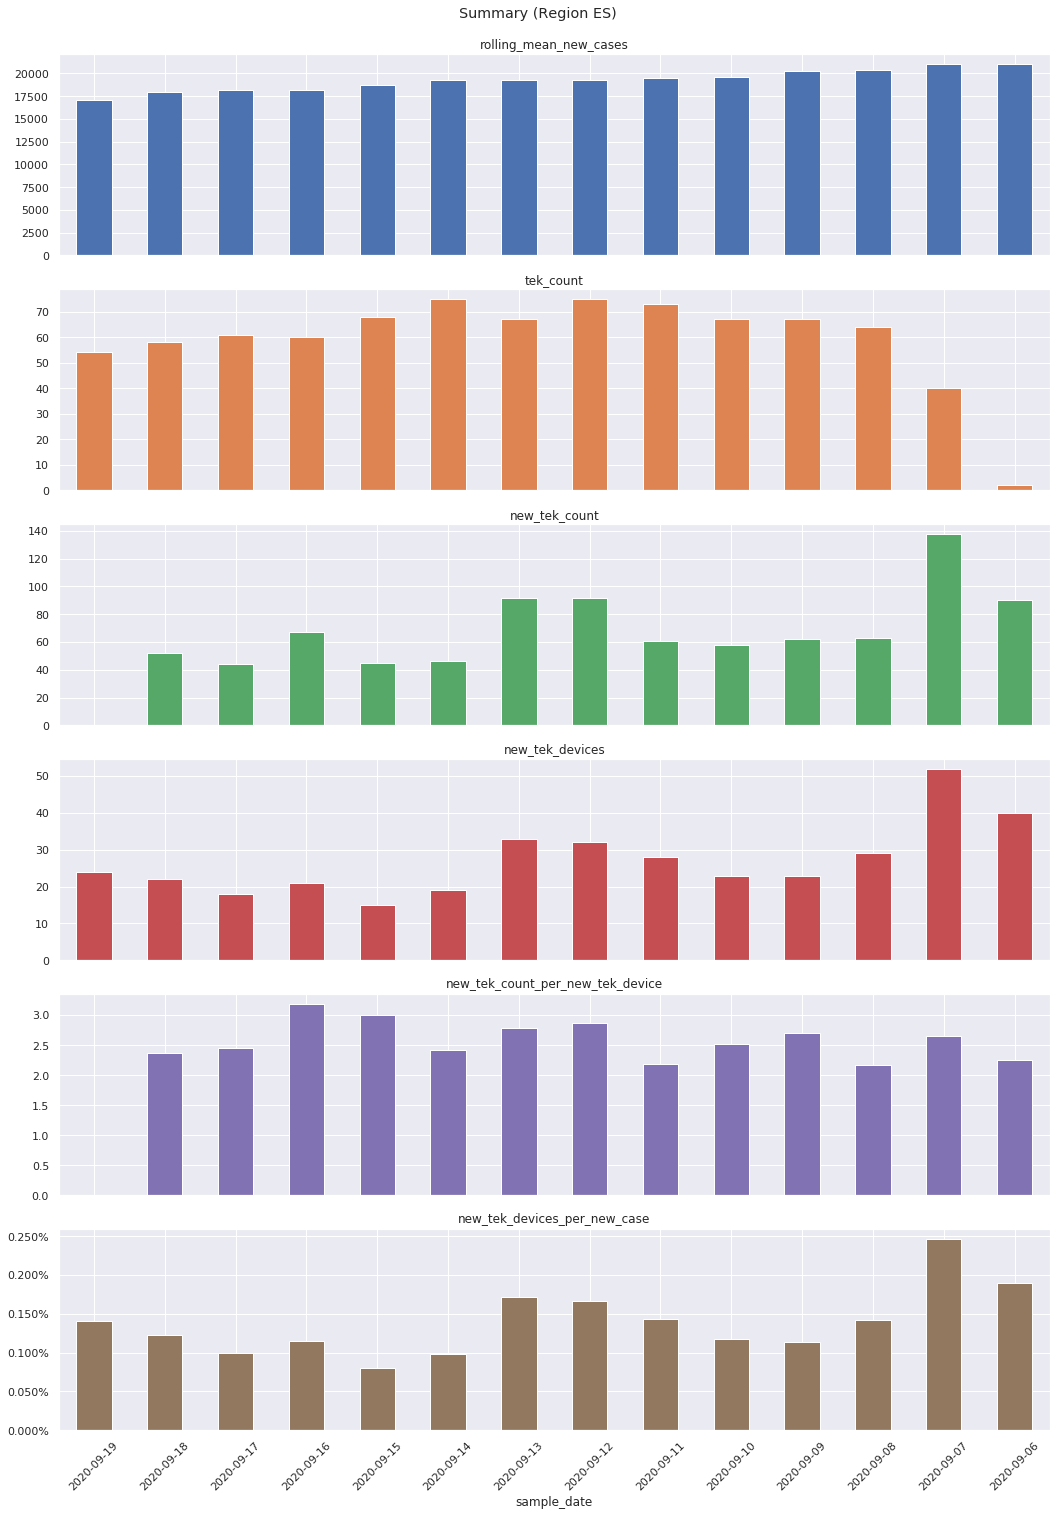

In [29]:
summary_ax_list = result_summary_df[[
    "rolling_mean_new_cases",
    "tek_count",
    "new_tek_count",
    "new_tek_devices",
    "new_tek_count_per_new_tek_device",
    "new_tek_devices_per_new_case"
]].sort_index(ascending=True).plot.bar(
    title=f"Summary (Region {spain_region_country_code})",
    rot=45, subplots=True, figsize=(15, 22), legend=False)
ax_ = summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.95)
ax_.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
_ = ax_.set_xticklabels(result_summary_df.index.strftime("%Y-%m-%d").tolist())

### Hourly Summary Plots 

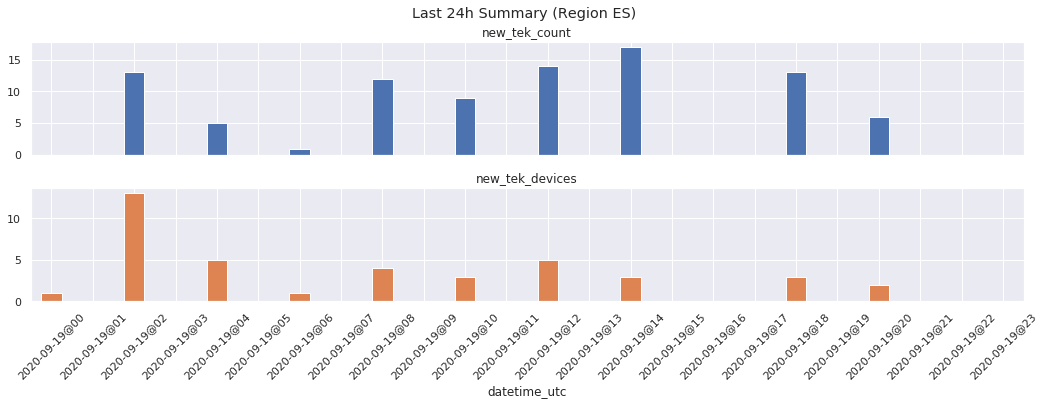

In [30]:
hourly_summary_ax_list = hourly_summary_df.plot.bar(
    title=f"Last 24h Summary (Region {spain_region_country_code})",
    rot=45, subplots=True, legend=False)
ax_ = hourly_summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.9)
_ = ax_.set_xticklabels(hourly_summary_df.index.strftime("%Y-%m-%d@%H").tolist())

### Summary Table

In [31]:
multi_region_summary_df

,tek_count
region,ES
sample_date_string,
2020-09-19,2
2020-09-18,40
2020-09-17,64
2020-09-16,67
2020-09-15,67
2020-09-14,73
2020-09-13,75
2020-09-12,67


### Publish Results

In [32]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

summary_plots_image_path = save_temporary_plot_image(ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(df=result_summary_df)
hourly_summary_plots_image_path = save_temporary_plot_image(ax=hourly_summary_ax_list)
multi_region_summary_table_image_path = save_temporary_dataframe_image(df=multi_region_summary_df)

### Save Results

In [33]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(report_resources_path_prefix + "Summary-Table.html")
multi_region_summary_df.to_csv(report_resources_path_prefix + "Multi-Region-Summary-Table.csv")
_ = shutil.copyfile(summary_plots_image_path, report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(summary_table_image_path, report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(hourly_summary_plots_image_path, report_resources_path_prefix + "Hourly-Summary-Plots.png")
_ = shutil.copyfile(multi_region_summary_table_image_path, report_resources_path_prefix + "Multi-Region-Summary-Table.png")

report_daily_url_pattern = \
    "https://github.com/pvieito/RadarCOVID-Report/blob/master/Notebooks/" \
    "RadarCOVID-Report/{report_type}/RadarCOVID-Report-{report_date}.ipynb"
report_daily_url = report_daily_url_pattern.format(
    report_type="Daily", report_date=extraction_date)
report_hourly_url = report_daily_url_pattern.format(
    report_type="Hourly", report_date=extraction_date_with_hour)

### Publish on README

In [34]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

summary_table_html = result_summary_df.to_html()
multi_region_summary_table_html = multi_region_summary_df.to_html()
readme_contents = readme_contents.format(
    summary_table_html=summary_table_html,
    multi_region_summary_table_html=multi_region_summary_table_html,
    report_url_with_hour=report_hourly_url,
    extraction_date_with_hour=extraction_date_with_hour)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [35]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule":
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    hourly_summary_plots_media = api.media_upload(hourly_summary_plots_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        hourly_summary_plots_media.media_id,
    ]

    extraction_date_result_summary_df = \
        result_summary_df[result_summary_df.index == extraction_date]
    extraction_date_result_hourly_summary_df = \
        hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

    new_teks = extraction_date_result_summary_df.new_tek_count.sum().astype(int)
    new_teks_last_hour = extraction_date_result_hourly_summary_df.new_tek_count.sum().astype(int)
    new_devices = extraction_date_result_summary_df.new_tek_devices.sum().astype(int)
    new_devices_last_hour = extraction_date_result_hourly_summary_df.new_tek_devices.sum().astype(int)
    new_tek_count_per_new_tek_device = \
        extraction_date_result_summary_df.new_tek_count_per_new_tek_device.sum()
    new_tek_devices_per_new_case = \
        extraction_date_result_summary_df.new_tek_devices_per_new_case.sum()

    status = textwrap.dedent(f"""
        Report Update – {extraction_date_with_hour}
        #ExposureNotification #RadarCOVID

        Shared Diagnoses Day Summary ({spain_region_country_code}):
        - New TEKs: {new_teks} ({new_teks_last_hour:+d} last hour)
        - New Devices: {new_devices} ({new_devices_last_hour:+d} last hour, {new_tek_count_per_new_tek_device:.2} TEKs/device)
        - Usage Ratio: {new_tek_devices_per_new_case:.2%} devices/case

        Active Regions: {", ".join(active_regions)}

        Report Link: {report_hourly_url}
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)